<a href="https://colab.research.google.com/github/RajuMekala01/ev_project/blob/main/EV_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem statement of the project
#####To predict the future EV adoption rate (total number of EVs) per county, enabling data-driven planning for charging infrastructure and grid-capacity upgrades.
#####This is a Regression problem. We are predicting a number (EV Count).

#Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

print("--- Libraries Imported ---")

--- Libraries Imported ---


## Load, Clean,and Aggregate data

In [3]:
print("\n--- Starting Phase 1 & 2: Load, Clean, and Aggregate ---")

# --- Load the raw data ---
file_path = "/content/Electric_Vehicle_Population_Data.csv.zip"
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded raw data: {len(df)} rows.")
except FileNotFoundError:
    print(f"ERROR: Could not find file at {file_path}")
    print("Please make sure the data file is in the same directory.")
    exit() # Stop the script if the file isn't found

# 1. 'DROP' (by selecting only columns we need)
columns_to_keep = ['County', 'Model Year', 'Electric Vehicle Type', 'Electric Range', 'Base MSRP']
df_clean = df[columns_to_keep].copy()

# 2. 'CLEAN' (Fix bad data)
# Replace '0' (missing data) with 'np.nan'
df_clean['Electric Range'] = df_clean['Electric Range'].replace(0, np.nan)
df_clean['Base MSRP']     = df_clean['Base MSRP'].replace(0, np.nan)

# Drop any rows where the 'County' is missing
df_clean = df_clean.dropna(subset=['County'])
print("Data cleaned (0s replaced with NaN, rows with no County dropped).")

# 3. 'GROUP BY' (The main aggregation step)
grouped = df_clean.groupby(['County', 'Model Year'])

# 4. CREATE OUR TARGET VARIABLE (y)
df_target = grouped.size().to_frame(name='EV_Count')

# 5. CREATE OUR FEATURES (X)
df_features_agg = grouped.agg(
    Avg_Electric_Range=('Electric Range', 'mean'),
    Avg_Base_MSRP=('Base MSRP', 'mean')
)

# 5b. Create the 'BEV_Ratio' feature
bev_counts = df_clean[df_clean['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)'].groupby(['County', 'Model Year']).size().to_frame(name='BEV_Count')
bev_counts = df_target.join(bev_counts)
bev_counts['BEV_Count'] = bev_counts['BEV_Count'].fillna(0)
df_features_agg['BEV_Ratio'] = bev_counts['BEV_Count'] / bev_counts['EV_Count']

# 6. COMBINE AND FINALIZE
# Join our target (df_target) with our features (df_features_agg)
model_df = df_target.join(df_features_agg)
# Fill any remaining 'nan' values with '0'
model_df = model_df.fillna(0)
# Turn the index (County, Model Year) back into columns
model_df = model_df.reset_index()

print(f"Data successfully aggregated into {len(model_df)} clean rows.")
print("--- Phase 1 & 2 Complete ---")


--- Starting Phase 1 & 2: Load, Clean, and Aggregate ---
Successfully loaded raw data: 124716 rows.
Data cleaned (0s replaced with NaN, rows with no County dropped).
Data successfully aggregated into 731 clean rows.
--- Phase 1 & 2 Complete ---


## Feature engineering & train-test split

In [4]:
print("\n--- Starting Phase 3: Feature Engineering & Train-Test Split ---")

# We must convert 'County' (text) to numbers for the model
# pd.get_dummies does this ("One-Hot Encoding")
X_features = pd.get_dummies(model_df.drop('EV_Count', axis=1),
                            columns=['County'],
                            drop_first=True) # drop_first=True helps avoid multicollinearity

# Our target variable (y)
y_target = model_df['EV_Count']

# --- The CRITICAL Time-Based Split ---
# We CANNOT shuffle. We must split by time.
# We will train on all data *before* 2022.
# We will test on all data *from* 2022 and 2023.
split_year = 2022
X_train = X_features[X_features['Model Year'] < split_year]
y_train = y_target[X_train.index]

X_test = X_features[X_features['Model Year'] >= split_year]
y_test = y_target[X_test.index]

print(f"Training on {len(X_train)} data points (Years < {split_year})")
print(f"Testing on {len(X_test)} data points (Years >= {split_year})")
print("--- Phase 3 Complete ---")


--- Starting Phase 3: Feature Engineering & Train-Test Split ---
Training on 606 data points (Years < 2022)
Testing on 125 data points (Years >= 2022)
--- Phase 3 Complete ---


## Model Training & Evalution

In [5]:
print("\n--- Starting Phase 4: Model Training & Evaluation ---")

# Initialize the model
# n_estimators=100 means 100 "decision trees"
# random_state=42 ensures you get the same results every time you run it
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all CPU cores

# Train (fit) the model on the training data
print("Training the model... (This may take a moment)")
model.fit(X_train, y_train)
print("Model training complete.")

# --- Evaluate the Model ---
# Use the trained model to make predictions on the 'test' data
y_pred = model.predict(X_test)

# Calculate our error metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation Results ---")
print(f"  R-Squared (R2):     {r2:.3f}")
print(f"  Mean Absolute Error (MAE): {mae:.3f} vehicles")
print("  (R2: 1.0 is perfect. MAE: 0.0 is perfect.)")

# --- 7. Understand the Model (Feature Importance) ---
print("\n--- Top 10 Most Important Features ---")
importances = model.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Show the Top 10 most important features
print(feat_imp_df.sort_values(by='Importance', ascending=False).head(10).to_markdown(index=False))

print("--- Phase 4 Complete ---")


--- Starting Phase 4: Model Training & Evaluation ---
Training the model... (This may take a moment)
Model training complete.

--- Model Evaluation Results ---
  R-Squared (R2):     0.809
  Mean Absolute Error (MAE): 116.688 vehicles
  (R2: 1.0 is perfect. MAE: 0.0 is perfect.)

--- Top 10 Most Important Features ---
| Feature            |   Importance |
|:-------------------|-------------:|
| Model Year         |   0.453974   |
| County_King        |   0.425011   |
| Avg_Electric_Range |   0.0284885  |
| County_Snohomish   |   0.025267   |
| BEV_Ratio          |   0.0217052  |
| Avg_Base_MSRP      |   0.0165155  |
| County_Pierce      |   0.0114205  |
| County_Clark       |   0.00817578 |
| County_Thurston    |   0.0032079  |
| County_Kitsap      |   0.00247905 |
--- Phase 4 Complete ---


## Visualizing the result


--- Starting Phase 5: Visualizing Results ---
Successfully saved evaluation plot to 'model_evaluation_plot.png'
--- Phase 5 Complete ---


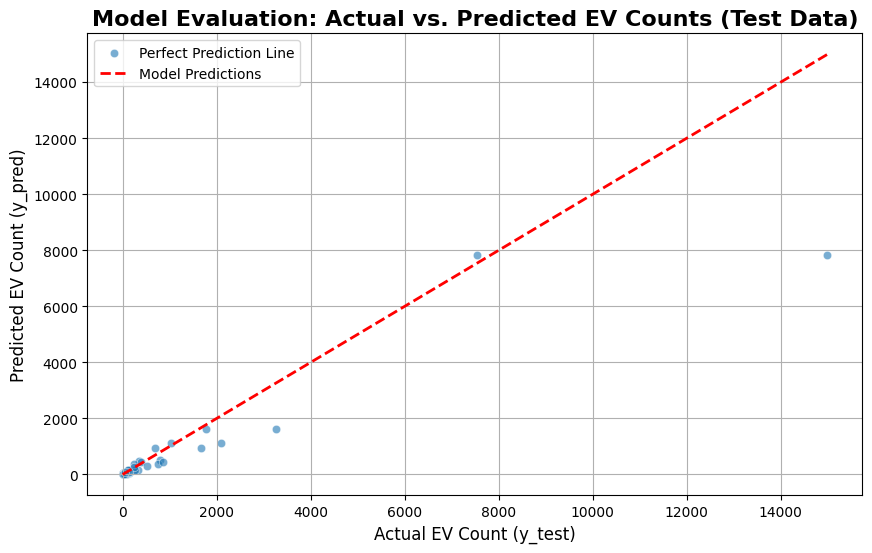

In [6]:
print("\n--- Starting Phase 5: Visualizing Results ---")

plt.figure(figsize=(10, 6))
# A scatter plot of real vs. predicted
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
# A 45-degree line showing "perfect" predictions
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.title('Model Evaluation: Actual vs. Predicted EV Counts (Test Data)', fontsize=16, fontweight='bold')
plt.xlabel('Actual EV Count (y_test)', fontsize=12)
plt.ylabel('Predicted EV Count (y_pred)', fontsize=12)
plt.legend(['Perfect Prediction Line', 'Model Predictions'])
plt.grid(True)

# Save the plot to a file
plot_filename = 'model_evaluation_plot.png'
plt.savefig(plot_filename, dpi=300)

print(f"Successfully saved evaluation plot to '{plot_filename}'")
print("--- Phase 5 Complete ---")